# Model recovery attack: `wine`

In [2]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import mra
from mra import *

In [3]:
def make_dataset(X, Y, f):
    x = tf.data.Dataset.from_tensor_slices(X)
    y = tf.data.Dataset.from_tensor_slices(Y)
    x = x.map(f)
    xy = tf.data.Dataset.zip((x, y))
    xy = xy.shuffle(10000)
    return xy

df = pd.read_excel('../datasets/credit-card.xls', header=1, index_col=0).sample(frac=1)
min_values = df.drop(columns=["default payment next month"]).describe().transpose()['min'].to_numpy()
max_values = df.drop(columns=["default payment next month"]).describe().transpose()['max'].to_numpy()
x = df.drop(columns=["default payment next month"]).to_numpy()
x = (x-min_values)/(max_values-min_values)
y = df["default payment next month"].to_numpy().reshape((len(x), 1)).astype("float32")
train_ds = make_dataset(x, y, lambda t: t)

mra = mra(train_ds)

In [4]:
def make_f(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.BatchNormalization()(xin)
    x = tf.keras.layers.Dense(64, activation="relu")(xin)
    output = tf.keras.layers.Dense(64, activation="relu")(x)
    return tf.keras.Model(xin, output)

def make_g(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Dense(64, activation="relu")(xin)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    # x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    return tf.keras.Model(xin, output)

In [5]:
log_train = mra.train(
    make_f,
    make_g,
    loss_fn=tf.keras.losses.binary_crossentropy,
    batch_size=32,
    epoch=5,
    lr=0.001,
    verbose=True, log_every=500
    )

Iteration 0001: Training loss: 0.6921
Iteration 0501: Training loss: 0.3510
Iteration 1001: Training loss: 0.3981
Iteration 1501: Training loss: 0.5392
Iteration 2001: Training loss: 0.5119
Iteration 2501: Training loss: 0.4610
Iteration 3001: Training loss: 0.3766
Iteration 3501: Training loss: 0.5604
Iteration 4001: Training loss: 0.2496
Iteration 4501: Training loss: 0.3958


In [6]:
def make_generator(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    act = "relu"
    x = tf.keras.layers.Dense(512, activation=act)(xin)
    x = tf.keras.layers.Dense(256, activation=act)(x)
    x = tf.keras.layers.Dense(128, activation=act)(x)
    x = tf.keras.layers.Dense(64, activation=act)(x)
    x = tf.keras.layers.Dense(32, activation=act)(x)
    x = tf.keras.layers.Dense(23, activation="sigmoid")(x)
    return tf.keras.Model(xin, x)

In [7]:
log_attack = mra.attack(
    attack_iter=1,
    make_generator=make_generator,
    input_noise="normal",
    input_z=True,
    model_leak=True,
    lr_x=0.001,
    lr_f=0.0001,
    epoch=200,
    iter_x=50,
    iter_f=1,
    verbose=True, log_every=1)

Iteration 0001: RG-uniform: 0.2202, RG-normal: 0.1944, reconstruction validation: 0.0072


In [ ]:
np.savetxt("./log/credit.csv", log_attack, delimiter=",")

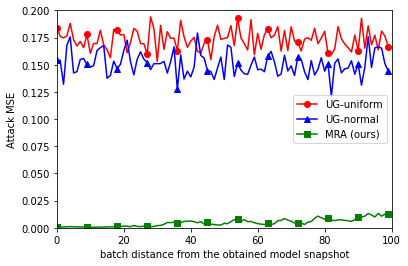

In [ ]:
plt.xlim([0,100])
plt.ylim([0,0.2])
plt.ylabel('Attack MSE')
plt.xlabel('batch distance from the obtained model snapshot')
ran = [i for i in range(100)]
plt.plot(ran, log_attack[:,0], 'ro-', ran, log_attack[:,1], 'b^-', ran, log_attack[:,2], 'gs-', markevery=np.arange(0, 101, 9))
plt.legend(['UG-uniform', 'UG-normal', 'MRA (ours)'], loc='center right')
plt.savefig("fig/credit.pdf", bbox_inches='tight')